# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
import re
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))
from gensim.models.phrases import Phrases, Phraser
from string import punctuation
punctuation = list(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Download the Dataset

In [3]:
!wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip

--2024-06-16 00:42:06--  https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip
Resolving onlineacademiccommunity.uvic.ca (onlineacademiccommunity.uvic.ca)... 142.104.197.46
Connecting to onlineacademiccommunity.uvic.ca (onlineacademiccommunity.uvic.ca)|142.104.197.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43106824 (41M) [application/zip]
Saving to: ‘News-_dataset.zip.1’

News-_dataset.zip.1 100%[===================>]  41.11M  3.37MB/s    in 12s     

2024-06-16 00:42:19 (3.34 MB/s) - ‘News-_dataset.zip.1’ saved [43106824/43106824]



In [4]:
!unzip News-_dataset.zip

Archive:  News-_dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
fake_data=pd.read_csv("Fake.csv")
true_data=pd.read_csv("True.csv")

In [6]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# **Exploratory Data Analysis (EDA)**

# Exploring Fake News dataset

In [8]:
fake_data.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
fake_data.shape

(23481, 4)

In [10]:
fake_data.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [11]:
fake_data["subject"].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [12]:
fake_data.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

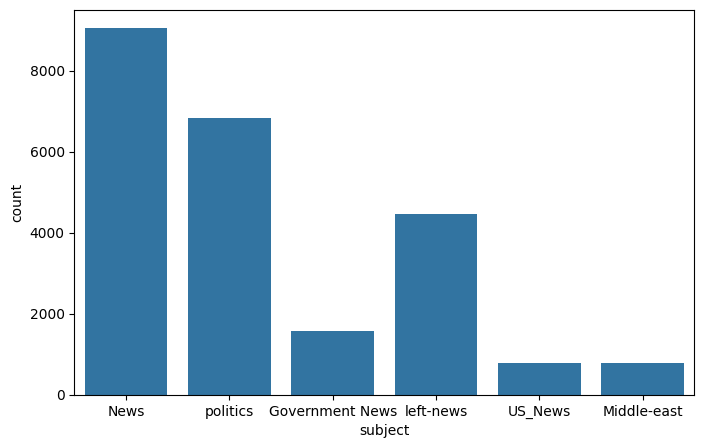

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=fake_data)
plt.show()

In [14]:
def most_common_words(corpus, nb_words):
    articles = corpus.str.split()
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurrences']).transpose().reset_index()
    d.columns=['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [ ]:
most_common_words(fake_data['text'],10)

# **Duplicates values**

In [15]:
fake_data = fake_data.drop_duplicates(subset=['text'], ignore_index=True)

In [16]:
duplicates = fake_data['text'].value_counts()[fake_data['text'].value_counts()>1]
duplicates

Series([], Name: count, dtype: int64)

In [17]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [19]:
fake_data['article'] = fake_data['title'] + '.' + fake_data['text']
del fake_data['title']
del fake_data['text']
fake_data["Label"]=1

In [18]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Exploring Real news

In [20]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=true_data)
plt.show()

In [ ]:
true_data.shape

In [ ]:
true_data.head()

In [21]:
duplicates = true_data['text'].value_counts()[true_data['text'].value_counts()>1]

In [22]:
true_data = true_data.drop_duplicates(subset=['text'], ignore_index=True)

In [23]:
true_data.shape

(21192, 4)

In [24]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [25]:
true_data['article'] = true_data['title'] + '.' + true_data['text']
del true_data['title']
del true_data['text']
true_data["Label"]=0

In [26]:
true_data.head()

,subject,date,article,Label
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",0
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,0
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,0
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,0


In [27]:
data = pd.concat([true_data, fake_data])
data.reset_index(drop=True, inplace=True)
print(data.shape)
data.head()

(38647, 4)


,subject,date,article,Label
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",0
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,0
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,0
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,0


In [28]:
del data["subject"]
del data["date"]

In [ ]:
data.head()

In [ ]:
# Plotting the pie chart
plt.figure(figsize=(6, 6))
data["Label"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')

# Adding title and showing the plot
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

In [ ]:
# Characters length of articles
len_cha_true = data[data['Label'] == 1]['article'].apply(lambda x: len(x))
len_cha_false = data[data['Label'] == 0]['article'].apply(lambda x: len(x))

bins_ = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins_, weights = np.ones(len(len_cha_true))/len(len_cha_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')

hist2.hist(len_cha_false, bins = bins_, weights = np.ones(len(len_cha_false))/len(len_cha_false), color = 'r')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

# **data preprocessing**

In [29]:
from tqdm.notebook import tqdm
stop = stopwords + punctuation + ['“','’', '“', '”', '‘','...']
tqdm.pandas()

def preprocessing(article):
    article=article.lower()
    article = re.sub("()", "", article, flags=re.DOTALL)
    article = re.sub(r'https?:\/\/.\S+', "", article)
    article = re.sub("#"," ",article)
    article = re.sub("@"," ",article)
    article = re.sub('', '', article)
    final_article = []
    for i in article.split():
        if i not in stop:
            final_article.append(i.strip())
    return " ".join(final_article)

In [30]:
data['article'] = data['article'].apply(lambda x : preprocessing(x))

In [ ]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud(corpus, title):
    wordcloud = WordCloud(width = 1000, height = 500, stopwords=STOPWORDS, background_color='white').generate(" ".join(corpus))
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
wordcloud(data[data['Label']==1]['article'], "WordCloud for True News")

In [ ]:
data.head()

In [ ]:
data["length"]=data["article"].apply(len)

In [ ]:
#display a representation of messages per each category
plt.figure(figsize=(12, 8))

data[data.Label == 1].length.plot(bins=35, kind='hist', color='blue',
                                        label='Fake articles', alpha=0.6)
data[data.Label == 0].length.plot(bins=35,kind='hist', color='red',
                                        label='True articles', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [ ]:
del data["length"]

In [31]:
pip install nltk

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [34]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def text_preprocess(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lowercase and remove special characters/punctuation
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
## apply the preprocessing steps defined in function text_preprocess
data["article"] = data["article"].apply(lambda x: text_preprocess(x))

In [ ]:
# Train the Logistic Regression
clf1 = LogisticRegression()
clf1.fit(X_train, y_train)

# Evaluate the model
y_pred = clf1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Data Cleaning

*Removing Reuters or Twitter Tweet information from the text*

*Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part<br>
*If we do not get text part, this means publication details was't given for that record<br>
*The Twitter tweets always have same source, a long text of max 259 characters

In [ ]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real_df.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real_df.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

**Looks like, 8970 index does not have any text**

In [ ]:
real_df.iloc[8970]
#yep empty
#will remove this soon

In [ ]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real_df.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)

        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
real_df["publisher"] = publisher
real_df["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [ ]:
real_df.head()

In [ ]:
 #checking for rows with empty text like row:8970
[index for index,text in enumerate(real_df.text.values) if str(text).strip() == '']
#seems only one :)

In [ ]:
#dropping this record
real_df.drop(8970, axis=0,inplace=True)

In [ ]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake_df.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_df.iloc[empty_fake_index].tail()

In [ ]:
fake_df.drop(empty_fake_index, axis=0,inplace=True)

In [ ]:
#WordCloud For Real News
text = ''
for news in real_df.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 2500,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Preprocessing Text

In [ ]:
# Adding class Information
real_df["class"] = 1
fake_df["class"] = 0

In [ ]:
#Combining Title and Text
real_df["text"] = real_df["title"] + " " + real_df["text"]
fake_df["text"] = fake_df["title"] + " " + fake_df["text"]

In [ ]:
# Subject is diffrent for real and fake thus dropping it
# And dropping Date, title and Publication Info of real
real_df = real_df.drop(["subject", "date","title",  "publisher"], axis=1)
fake_df = fake_df.drop(["subject", "date", "title"], axis=1)

In [ ]:
real_df.head()

In [ ]:
fake_df.head()

In [ ]:
#Combining both into new dataframe
df = real_df.append(fake_df, ignore_index=True)
del real_df, fake_df

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
y = df["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del df

In [ ]:
X[:1]

In [ ]:
y[:5]

In [ ]:
y[-5:]

In [ ]:
import gensim

### Vectorization -- Word2Vec
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122238 words by a 100dim vector.

In [ ]:
#see a sample vector for random word, lets say House
w2v_model["house"]

In [ ]:
w2v_model.wv.most_similar("trump")

In [ ]:
w2v_model.wv.most_similar("america")

In [ ]:
w2v_model.wv.most_similar("fbi")

In [ ]:
w2v_model.wv.most_similar("google")

In [ ]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors.

Keras has implementation called **"Embedding Layer"** which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.

We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

In [ ]:
#Lets check few word to numerical reprsentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

**Notice it starts with 1**

We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input

In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :)

In [ ]:
len(y)

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
## Out of 44k news, 43k have less than 700 words

In [ ]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=7)

In [ ]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
del model

In [ ]:
#invoke garbage collector to free ram
import gc
gc.collect()

### Comments
99% Accuracy looks like unusual. But model is developed carefully to avoid overfitting. As well as, removed some specific word to avoid biasness(Reuters..). I think, it's the problem of dataset which may have some indicator which leads to high accuracy. So, it's not guranteed that this model may not work up to the marks for another new dataset.

#### Important Notes

Datasete is collected from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/download)  <br>
Model is developed based on kernel of [Atish Adhikari](https://www.kaggle.com/atishadhikari/)